# Waveguide Crossing

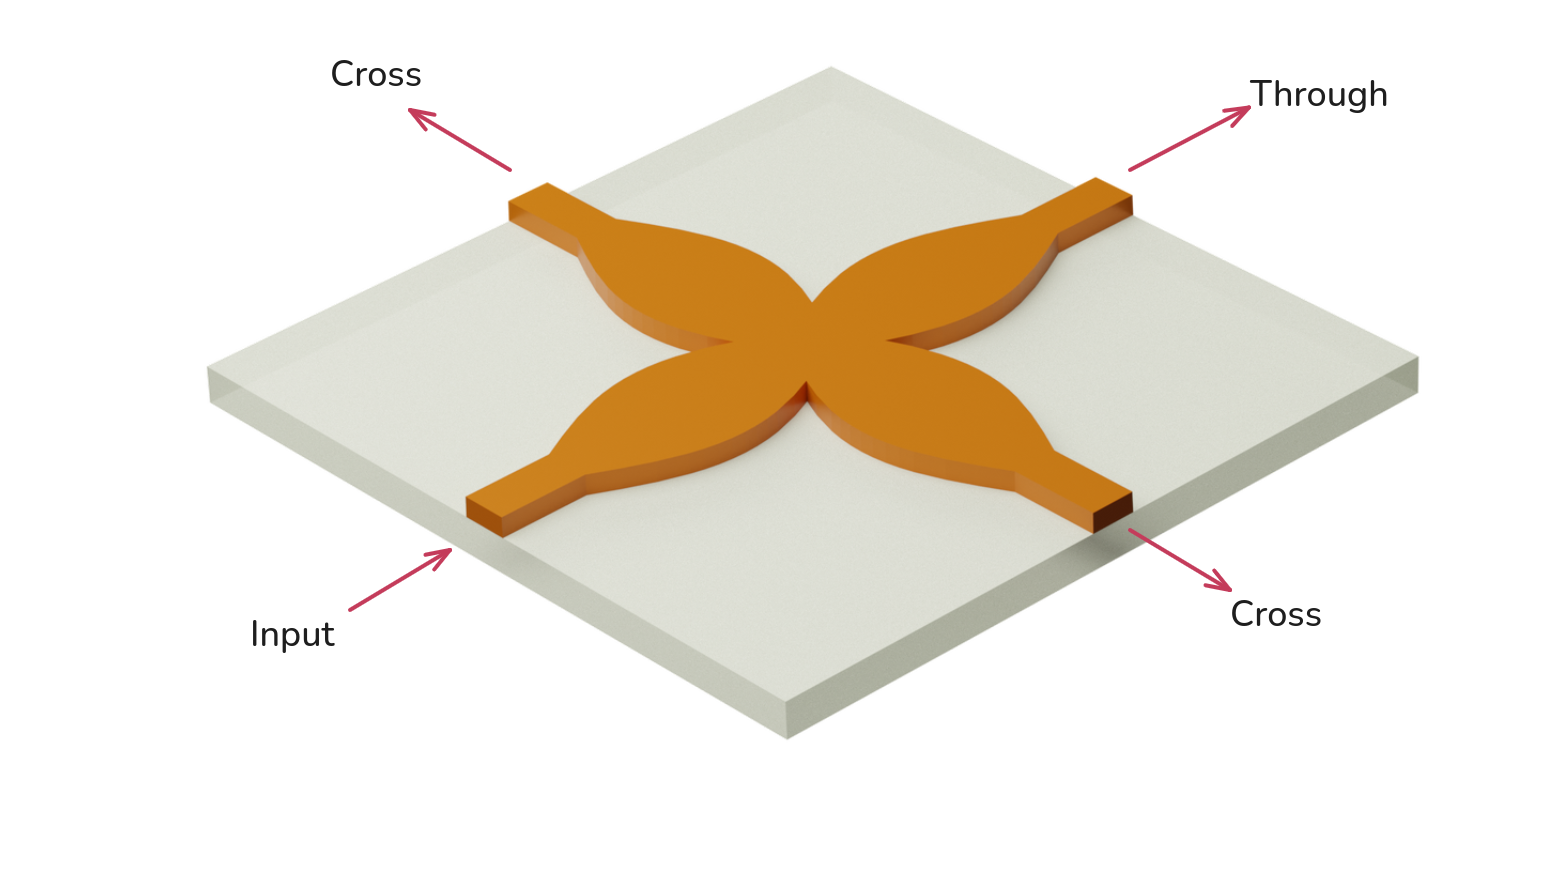

This example uses of PhotonForge to optimize a waveguide crossing based on \[1].
A Monte Carlo parameter sweep is used to explore the initial design space and provide a good optimization starting point.
The local optimization uses the Nelder-Mead method based on scipy's [minimize function](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html).

**References**

1. Sujith Chandran, Marcus Dahlem, Yusheng Bian, Paulo Moreira, Ajey P. Jacob, Michal Rakowski, Andy Stricker, Karen Nummy, Colleen Meagher, Bo Peng, Abu Thomas, Shuren Hu, Jan Petykiewicz, Zoey Sowinski, Won Suk Lee, Rod Augur, Dave Riggs, Ted Letavic, Anthony Yu, Ken Giewont, John Pellerin, and Jaime Viegas, "Beam shaping for ultra-compact waveguide crossings on monolithic silicon photonics platform," *Opt. Lett.* **45**, 6230-6233 (2020), doi: [10.1364/OL.402446](https://doi.org/10.1364/OL.402446)

This example has a similar Tidy3D version: [Waveguide crossing based on cosine tapers](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/WaveguideCrossing.html).

In [1]:
import numpy as np
import scipy.optimize
import photonforge as pf
import tidy3d as td
from matplotlib import pyplot as plt

For this demonstration, the [basic_technology](../_autosummary/photonforge.basic_technology.rst) is enough to show the main concepts behind it.
Other [technologies](../guides/Technology.ipynb) can be equally used to optimize the crossing for other PDKs.

In [2]:
tech = pf.basic_technology()
pf.config.default_technology = tech

## Geometry Parametrization

PhotonForge provides a flexible [crossing](../_autosummary/photonforge.parametric.crossing.rst) [parametric component](../guides/Parametric_Component_Library.ipynb) that can be directly used to re-create the cosine-tapered geometry proposed in the main reference.

We create a custom function with the parameters we're interested in optimizing as variables.
Although possible, we don't really need to make this function a [parametric component function](../_autosummary/photonforge.parametric_component.rst) only to optimize those parameters, considering we already return a parametric crossing from it.

Besides the re-parametrization, we also set the [Tidy3D model](../guides/Tidy3D_Model.ipynb)'s arguments to remove verbosity and increase the default run time because, depending on the exact parameters, the geometry can become resonant.

In [3]:
def sine_crossing(amplitude, arm_length):
    tidy3d_model_kwargs = {"verbose": False, "run_time": 3e-12}
    crossing = pf.parametric.crossing(
        port_spec="Strip",
        arm_length=arm_length,
        extra_length=0.5,
        added_width=f"{amplitude} * sin(pi * u)",
        tidy3d_model_kwargs=tidy3d_model_kwargs,
    )
    return crossing


sine_crossing(arm_length=3, amplitude=1)

## Monte Carlo Exploration

The initial exploration of the parameter space is done with the help of the [Monte Carlo](../monte_carlo.rst) tools in PhotonForge.
We can calculate a range of [S parameters](../guides/S_Parameters.ipynb) for variations of the crossing by setting its parameters as random variables within a fixed value range.
The ranges are quite wide because we know almost nothing *a priori* about the design, therefore the number of samples is also considerably high to allow proper exploration of the whole space.

Note that because we are only interested in the transmission from P0 to P2, we explicitly set the ports and modes we want to run as sources for the Tidy3D simulations using the `inputs` argument.

In [4]:
freqs = pf.C_0 / np.linspace(1.45, 1.65, 21)

variables, results = pf.monte_carlo.s_matrix(
    sine_crossing,
    freqs,
    ("amplitude", "component", {"value_range": (0.1, 1.5)}),
    ("arm_length", "component", {"value_range": (0.5, 3)}),
    random_samples=30,
    component_kwargs={"amplitude": 1, "arm_length": 3},
    model_kwargs={"inputs": ["P0@0"]},
    random_seed=0,
)

Starting sample 1 of 30…


Starting sample 2 of 30…


Starting sample 3 of 30…


Starting sample 4 of 30…


Starting sample 5 of 30…


Starting sample 6 of 30…


Starting sample 7 of 30…


Starting sample 8 of 30…


Starting sample 9 of 30…


Starting sample 10 of 30…


Starting sample 11 of 30…


Starting sample 12 of 30…


Starting sample 13 of 30…


Starting sample 14 of 30…


Starting sample 15 of 30…


Starting sample 16 of 30…


Starting sample 17 of 30…


Starting sample 18 of 30…


Starting sample 19 of 30…


Starting sample 20 of 30…


Starting sample 21 of 30…


Starting sample 22 of 30…


Starting sample 23 of 30…


Starting sample 24 of 30…


Starting sample 25 of 30…


Starting sample 26 of 30…


Starting sample 27 of 30…


Starting sample 28 of 30…


Starting sample 29 of 30…


Starting sample 30 of 30…


Sample 1 done.
Sample 2 done.


Sample 3 done.
Sample 4 done.


Sample 5 done.
Sample 6 done.


Sample 7 done.
Sample 8 done.


Sample 9 done.
Sample 10 done.


Sample 11 done.
Sample 12 done.


Sample 13 done.
Sample 14 done.


Sample 15 done.
Sample 16 done.


Sample 17 done.
Sample 18 done.


Sample 19 done.
Sample 20 done.


Sample 21 done.
Sample 22 done.


Sample 23 done.
Sample 24 done.


Sample 25 done.
Sample 26 done.


Sample 27 done.
Sample 28 done.


Sample 29 done.
Sample 30 done.
All samples done!


The results include the full [S matrix](../_autosummary/photonforge.SMatrix.rst) for each crossing variation.
To help us make sense of all this data, we can define a figure of merit for the design and plot it versus the crossing parameters.
In this case, a reasonable definition is to use the minimal transmission value within the frequency range we're interested in.
Let's first create a result table with only the parameters and our figure of merit, instead of the whole S matrix objects:

In [5]:
names = [v.name for v in variables]
table = np.array([(*v, np.abs(s["P0@0", "P2@0"]).min() ** 2) for *v, s in results])
table

array([[1.89293245, 1.30670413, 0.05530222],
       [1.78530457, 0.95793781, 0.34169469],
       [1.57431442, 0.15939063, 0.73253572],
       [1.39931042, 1.10239893, 0.15700649],
       [1.74379972, 1.32907849, 0.02178808],
       [0.66835153, 0.56466724, 0.42768961],
       [2.07250101, 1.05543504, 0.49929728],
       [2.45512328, 0.64501438, 0.84392162],
       [2.55332675, 0.68507742, 0.87109087],
       [2.12682069, 0.21543469, 0.72220421],
       [0.98118614, 0.76343902, 0.34215722],
       [2.66823248, 0.38698483, 0.7100946 ],
       [1.46807783, 1.44878793, 0.21179315],
       [1.94662566, 0.60877627, 0.93309099],
       [2.92168546, 0.83047987, 0.85355283],
       [2.35086521, 0.36836535, 0.71441003],
       [0.86364256, 0.28845985, 0.71320476],
       [2.24903115, 1.48379688, 0.02546598],
       [2.26344246, 1.15381968, 0.54604638],
       [2.87219256, 1.0157638 , 0.61065718],
       [0.59253126, 0.90813608, 0.44463409],
       [1.26638186, 0.50425125, 0.67683665],
       [1.

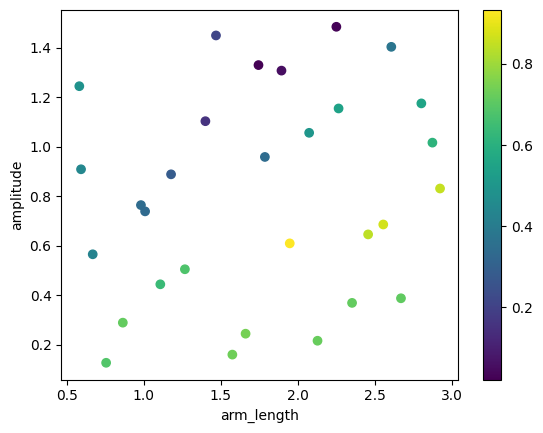

In [6]:
plt.scatter(table[:, 0], table[:, 1], c=table[:, 2])
plt.xlabel(names[0])
plt.ylabel(names[1])
_ = plt.colorbar()

## Local Optimization

We use scipy to optimize the crossing around the best result we found through the Nelder-Mead method, which does not require a gradient computation.
More advanced optimization methods based on ajoint computations are available in Tidy3D directly, if the device require those due to, for example, a large number of parameters.

The only step required to run the optimization is the creation of an objective function to be *minimized*.
It receives arguments as an array, which we decompose into the 2 parameters for our crossing.
Furthermore, because we desire to *maximize* the minimal transmission, we use a negative sign in our figure of merit:

In [7]:
def objective(args):
    kwargs = dict(zip(names, args))
    c = sine_crossing(**kwargs)
    s_matrix = c.s_matrix(freqs)
    min_transmission = np.abs(s_matrix["P0@0", "P2@0"]).min() ** 2

    # We can print the current evaluation result to keep track of the optimization process
    print(args, "→", min_transmission, flush=True)

    return -min_transmission

For the actual optimization run, we limit the convergence tolerances to reasonable values, as well as the number of function evaluations so that we don't run unnecessary simulations.
If those values end up being too small, we can always restart the optimization from the last best parameters.

In [8]:
best_variation = np.argmax(table[:, 2])
initial_guess = (table[best_variation, 0], table[best_variation, 1])

opt_result = scipy.optimize.minimize(
    objective,
    initial_guess,
    method="Nelder-Mead",
    bounds=[v.value_spec["value_range"] for v in variables],
    options={"maxfev": 16, "fatol": 0.005, "xatol": 0.005},
)
opt_result

Progress: 100% 


[1.94662566 0.60877627] → 0.9330909860251679


Progress: 100% 


[2.04395694 0.60877627] → 0.9338210421314378


Progress: 100% 


[1.94662566 0.63921508] → 0.9088085211876892


Progress: 100% 


[2.04395694 0.57833745] → 0.9209370020392426


Progress: 100% 


[2.01962412 0.59355686] → 0.9309397238621958


Progress: 100% 


[1.97095848 0.62399567] → 0.9277377710992789


Progress: 100% 


[2.00745771 0.60116656] → 0.9344141500023974


Progress: 100% 


[2.10478899 0.60116656] → 0.9230254642029422


Progress: 100% 


[1.98616649 0.60687384] → 0.9359538224303601


Progress: 100% 


[1.94966726 0.59926414] → 0.9328117733383428


Progress: 100% 


[2.02038452 0.60639823] → 0.9345441635731953


Progress: 100% 


[1.9990933  0.61210551] → 0.9372762099170099


Progress: 100% 


[1.9949111  0.61757499] → 0.9363144038080655


Progress: 100% 


[1.96487527 0.61258112] → 0.9358456985967134


Progress: 100% 


[1.97875259 0.6110354 ] → 0.9363370918125409


Progress: 100% 


[1.9916794  0.61626707] → 0.9373395993809784


       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: -0.9372762099170099
             x: [ 1.999e+00  6.121e-01]
           nit: 7
          nfev: 16
 final_simplex: (array([[ 1.999e+00,  6.121e-01],
                       [ 1.979e+00,  6.110e-01],
                       [ 1.986e+00,  6.069e-01]]), array([-9.373e-01, -9.363e-01, -9.360e-01]))

## Inspecting the Optimized Component

We can recreate the best variation for out technology and reset its model to remove the helper symmetries and include a [field monitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html#tidy3d.FieldMonitor) if we want to fully inspect the component.
Of course, with our parameters being layout dimensions, we should not use an arbitrary number of decimals, so we round them appropriately: in this case, 2 decimals (10 nm grid) should suffice.

Loading cached simulation from .tidy3d/pf_cache/5YT/fdtd_info-5XR4NVE6Q5HWKQXTFPU2P7ZJQVUKHOYNWIWKFRKATW3NVJ7OXUEA.json.


Loading cached simulation from .tidy3d/pf_cache/5YT/fdtd_info-LWQAOI2FPVBMXXPOECFDHECPNODIOL2MIYMRDKTXASDJWBTQEGEQ.json.
Loading cached simulation from .tidy3d/pf_cache/5YT/fdtd_info-3JQWAS64HRPVRAEH2JOTCK4L3TZLGIAEKL2YV6ZRAQSHGNT75YCA.json.


Loading cached simulation from .tidy3d/pf_cache/5YT/fdtd_info-EMKWF6KW2URZO7K5SIKTNIZ2372NKPFJG5ZML56VY6HKOWXVCOEQ.json.
Progress: 100% 


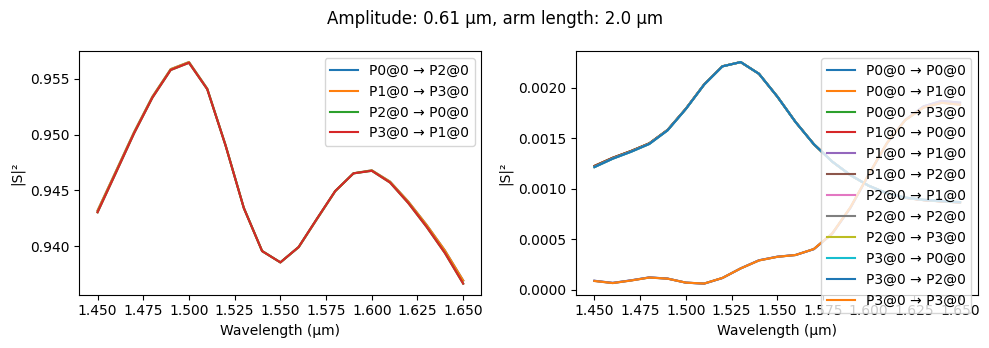

In [9]:
kwargs = dict(zip(names, np.round(opt_result.x, decimals=2)))

crossing = sine_crossing(**kwargs)

tidy3d_model = pf.Tidy3DModel(
    monitors=[
        td.FieldMonitor(
            name="field",
            center=(0, 0, 0.11),
            size=(td.inf, td.inf, 0),
            freqs=[freqs.mean()],
        )
    ]
)

crossing.add_model(tidy3d_model, "Tidy3D")

s_matrix = crossing.s_matrix(freqs)
fig, ax = pf.plot_s_matrix(s_matrix)
_ = fig.suptitle(f"Amplitude: {kwargs['amplitude']} μm, arm length: {kwargs['arm_length']} μm")

In order to plot the fields, we can use the [batch_data_for](../_autosummary/photonforge.Tidy3DModel.rst#photonforge.Tidy3DModel.batch_data_for) function from the Tidy3D model to get the [BatchData](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.web.api.container.BatchData.html) that includes the fields from our extra monitor:

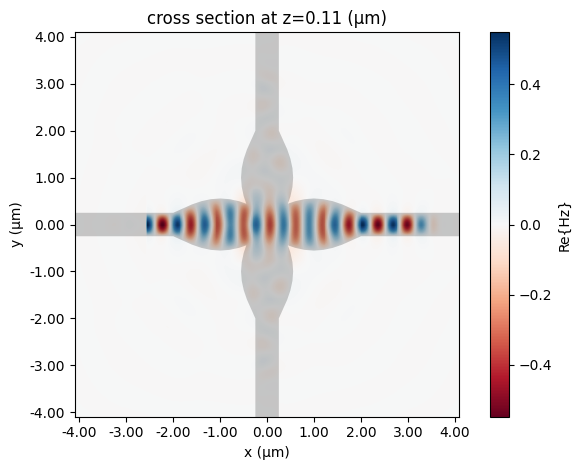

In [10]:
sim_data = tidy3d_model.batch_data_for(crossing)
_ = sim_data["P0@0"].plot_field("field", "Hz", robust=False)